# Limit setting
Look at the case of a massless neutrino and see how well we can set upper limits given some event rate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pytensor.tensor as pt
import scipy.constants as const

from utils import ApproxdGammadE, CalcMuSignal, CalcMuSignal_pytensor, CalculateR, OptimalDeltaE, Calculate90CL, GenerateBkgEvents

In [2]:
# Allow LaTeX in plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
def GenerateSignalEvents(numDens: float, tLive: float, volume: float, mNu: float, E0: float,
                         energyWindow: tuple[float, float] = (18.5e3, 18.7e3)):
    """
    Generate simulated neutrino mass events.

    Parameters
    ----------
    numDens : float
        Number density of tritium atoms in m^-3
    tLive : float
        Live time of the detector in seconds
    volume : float
        Effective volume of the detector in m^3
    mNu : float
        Neutrino mass in eV
    E0 : float
        Endpoint energy in eV 
    energyWindow : tuple of float, optional
        Energy window for the events in eV (default is (17.7, 18.7))

    Returns
    -------
    np.ndarray
        Array of generated event energies in keV
    """
    # Calculate the total number of decays in the time and volume
    nAtoms =  numDens * volume
    HALF_LIFE_T = 12.33 * 365.25 * 24 * 3600  # seconds
    DECAY_RATE_T = np.log(2) / HALF_LIFE_T  # s^-1
    N_DECAYS_FULL = nAtoms * DECAY_RATE_T * tLive  # Total decays in the time and volume

    # Need to calculate the decay rate in the energy window
    eMin, eMax = energyWindow
    # Generate the decay rates with a spacing of 5 meV
    energies = np.arange(energyWindow[0], energyWindow[1], 5e-3)  # in eV
    decayRatesSpec = ApproxdGammadE(mNu, E0, energies)
    # Integrate the decay rate over the energy window
    decayRateSpec = np.trapz(decayRatesSpec, energies)
    N_DECAYS_SPEC = nAtoms * decayRateSpec * tLive

    # Generate the events from a Poisson distribution with the mean equal to the 
    # number of decays in the energy window
    nEvents = np.random.poisson(N_DECAYS_SPEC)
    # Draw the energies from the decay rate spectrum
    cdf = np.cumsum(decayRatesSpec * np.diff(energies, prepend=energies[0]))
    cdf /= cdf[-1]  # Normalize to 1
    uniformSamples = np.random.uniform(0, 1, nEvents)
    eventEnergies = np.interp(uniformSamples, cdf, energies)
    return eventEnergies  # Convert to keV

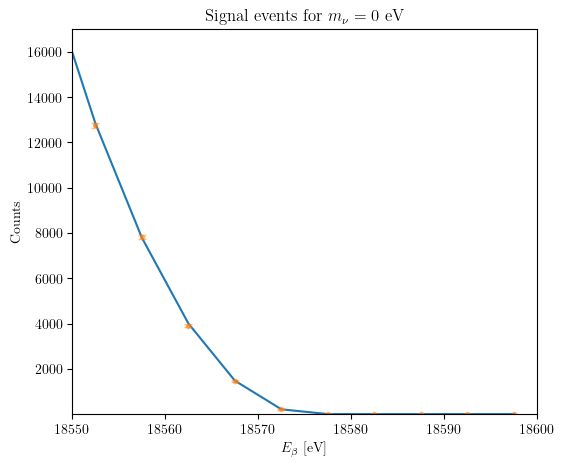

In [4]:
# Plot the decay spectrum
ENERGY_WINDOW = (18.45e3, 18.6e3)  # in eV
ENDPOINT_ENERGY_EV = 18.575e3  # in eV
NU_MASS_EV = 0.0  # in eV

NUM_DENS = 1e17  # in m^-3
T_LIVE = 365.25 * 24 * 3600  # in seconds (1 year)
T_VOLUME = 1e-3  # in m^3 (1 L)

sigEvents0eV = GenerateSignalEvents(NUM_DENS, T_LIVE, T_VOLUME, NU_MASS_EV, 
                                    ENDPOINT_ENERGY_EV, ENERGY_WINDOW)

energyBins = np.arange(ENERGY_WINDOW[0], ENERGY_WINDOW[1] + 5.0, 5.0)  # in eV
sigBins0eV, sigEdges = np.histogram(sigEvents0eV, bins=energyBins)
sigErrors0eV = np.sqrt(sigBins0eV)  # Poisson errors
sigCentres = (sigEdges[:-1] + sigEdges[1:]) / 2  # Bin centres in eV

fix, ax = plt.subplots(1, 1, figsize=(6, 5))
testE = np.linspace(ENERGY_WINDOW[0], ENERGY_WINDOW[1], 1000)

# Sub-divide the energy bins for to integrate the decay rate
sigMu0eV = CalcMuSignal(NU_MASS_EV, ENDPOINT_ENERGY_EV, sigEdges, T_LIVE, 
                        NUM_DENS, T_VOLUME, subdivisionStep=5e-3)

ax.plot(sigCentres, sigMu0eV, label='Calculated number of events')
ax.set_xlabel(r'$E_\beta$ [eV]')
ax.set_ylabel(r'Counts')
ax.set_xlim(18.55e3, 18.6e3)
ax.set_ylim(0.5, 17000)
ax.set_title(r'Signal events for $m_\nu = 0$ eV')

ax.errorbar(sigCentres, sigBins0eV, yerr=sigErrors0eV, fmt='o', 
            label='Sampled events', markersize=3, capsize=3, alpha=0.5)

plt.show()

In [5]:
myR = CalculateR(NUM_DENS, T_VOLUME) # Signal rate in last eV
print(f"Signal rate in last eV {myR:.2e} counts/s")
myB = 1e-6  # Background rate in counts per second per eV
dE = OptimalDeltaE(myR, myB)
print(f"Optimal energy resolution = {dE:.2e} eV")

# Calculate expected nu mass limit from single bin analysis
mnu_90CL = Calculate90CL(myR, myB, T_LIVE)
print(f"Expected 90% CL limit on m_nu = {mnu_90CL:.2e} eV")

Signal rate in last eV 3.56e-08 counts/s
Optimal energy resolution = 5.30e+00 eV
Expected 90% CL limit on m_nu = 2.05e+00 eV


Generated 4768 background events


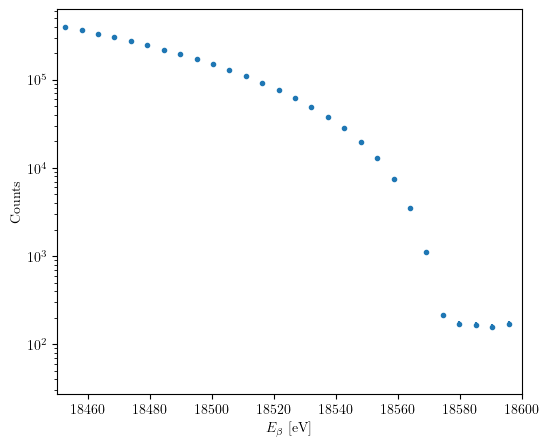

In [6]:
# Generate the histogram binning according to the optimal energy resolution
binsOpt = np.arange(ENERGY_WINDOW[0], ENERGY_WINDOW[1] + dE, dE)

# Generate background events
bkgEvents = GenerateBkgEvents(myB, T_LIVE, ENERGY_WINDOW)
print(f"Generated {bkgEvents.shape[0]} background events")

totalEvents = np.concatenate((sigEvents0eV, bkgEvents))
totalHist, totalHistEdges = np.histogram(totalEvents, bins=binsOpt)
totalHistCentres = (totalHistEdges[:-1] + totalHistEdges[1:]) / 2 
totalHistErrors = np.sqrt(totalHist)  # Poisson errors

fix, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.errorbar(totalHistCentres, totalHist, yerr=totalHistErrors, fmt='o', 
            label='Total events', color='C0', markersize=3)
ax.set_xlabel(r'$E_\beta$ [eV]')
ax.set_ylabel('Counts')
ax.set_xlim(ENERGY_WINDOW[0], ENERGY_WINDOW[1])
ax.set_yscale('log')

In [15]:
binEdgesPt = pt.as_tensor_variable(totalHistEdges)
nBins = len(totalHistCentres)
binCentresPt = (binEdgesPt[:-1] + binEdgesPt[1:]) / 2
STEP_SIZE = 5e-3  # eV

with pm.Model() as signalPlusBkg:
    # Define priors
    m_nu = pm.HalfNormal('m_nu', sigma=4.0)  # Neutrino mass in eV
    nT_DIV17 = pm.Normal('nT', mu=NUM_DENS / 1e17, sigma=2e16 / 1e17)
    bkgRate = pm.HalfNormal('bkgRate', sigma=myB * 4)  # Background rate in counts per second per eV
    E0 = ENDPOINT_ENERGY_EV

    bkgMu = bkgRate * T_LIVE * (binEdgesPt[1:] - binEdgesPt[:-1])

    sigMu = CalcMuSignal_pytensor(m_nu, E0, totalHistEdges, T_LIVE, nT_DIV17 * 1e17,
                                  T_VOLUME, subdivisionStep=STEP_SIZE)
    muTot = sigMu + bkgMu
    Y_obs = pm.Poisson('Y_obs', mu=muTot + 1e-40, observed=totalHist)

    trace = pm.sample_prior_predictive(samples=1000)

Sampling: [Y_obs, bkgRate, m_nu, nT]


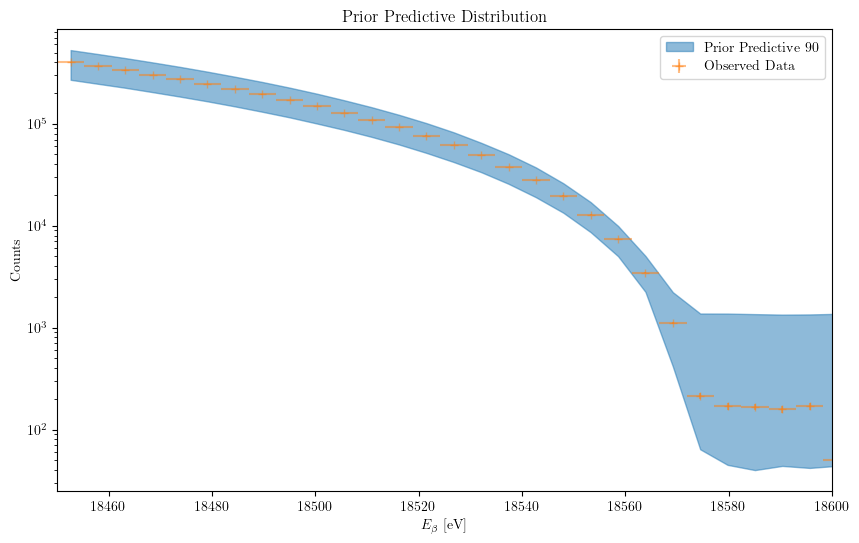

In [16]:
pp = trace.prior_predictive

plt.figure(figsize=(10, 6))

plt.fill_between(totalHistCentres, np.percentile(pp.Y_obs[0,:,:], 5.0, axis=0), 
                 np.percentile(pp.Y_obs[0,:,:], 95.0, axis=0), 
                 label='Prior Predictive 90% CI', color='C0', alpha=0.5)
plt.errorbar(totalHistCentres, totalHist, xerr=(totalHistEdges[1]-totalHistEdges[0])/2, 
             yerr=totalHistErrors, fmt='+', label='Observed Data', color='C1', alpha=0.5)
plt.xlabel(r'$E_\beta$ [eV]')
plt.ylabel('Counts')
plt.title('Prior Predictive Distribution')
plt.legend()
plt.yscale('log')
plt.xlim(ENERGY_WINDOW[0], ENERGY_WINDOW[1])
plt.show()

In [17]:
with signalPlusBkg:
    trace.extend(pm.sample(6000, tune=2000, return_inferencedata=True, target_accept=0.97))
    posterior = pm.sample_posterior_predictive(trace, var_names=['Y_obs'])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_nu, nT, bkgRate]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 147 seconds.
Sampling: [Y_obs]


Output()

array([[<Axes: title={'center': 'nT'}>, <Axes: title={'center': 'nT'}>],
       [<Axes: title={'center': 'm_nu'}>,
        <Axes: title={'center': 'm_nu'}>],
       [<Axes: title={'center': 'bkgRate'}>,
        <Axes: title={'center': 'bkgRate'}>]], dtype=object)

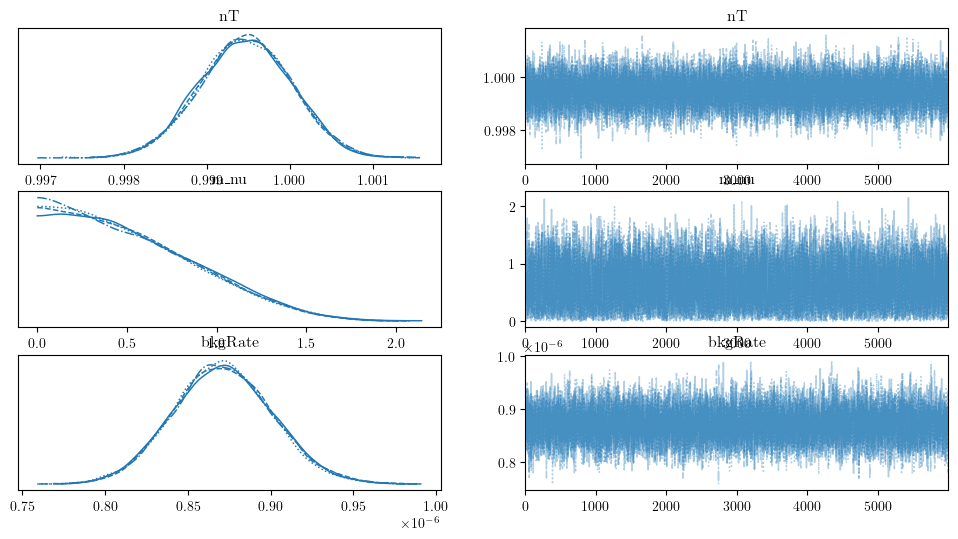

In [18]:
az.plot_trace(trace, combined=False)

Posterior predictive shape: (24000, 29)


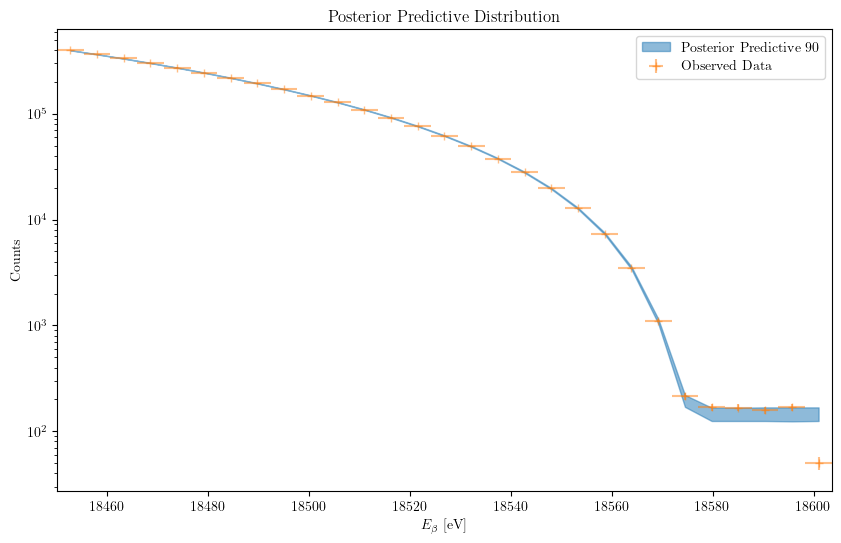

In [23]:
# Plot the posterior predictive distribution
post_pred = posterior.posterior_predictive['Y_obs'].to_numpy().reshape(-1, totalHistCentres.shape[0])
print(f"Posterior predictive shape: {post_pred.shape}")

plt.figure(figsize=(10, 6))
plt.fill_between(totalHistCentres, np.percentile(post_pred, 5.0, axis=0), 
                 np.percentile(post_pred, 95.0, axis=0), 
                 label='Posterior Predictive 90% CI', color='C0', alpha=0.5)
plt.errorbar(totalHistCentres, totalHist, xerr=(totalHistEdges[1]-totalHistEdges[0])/2, 
             yerr=totalHistErrors, fmt='+', label='Observed Data', color='C1', alpha=0.5)
plt.xlabel(r'$E_\beta$ [eV]')
plt.ylabel('Counts')
plt.title('Posterior Predictive Distribution')
plt.legend()
plt.yscale('log')
plt.xlim(totalHistEdges[0], totalHistEdges[-1])
plt.show()

One-sided 90% credible interval for m_nu: 1.092761973101642 eV


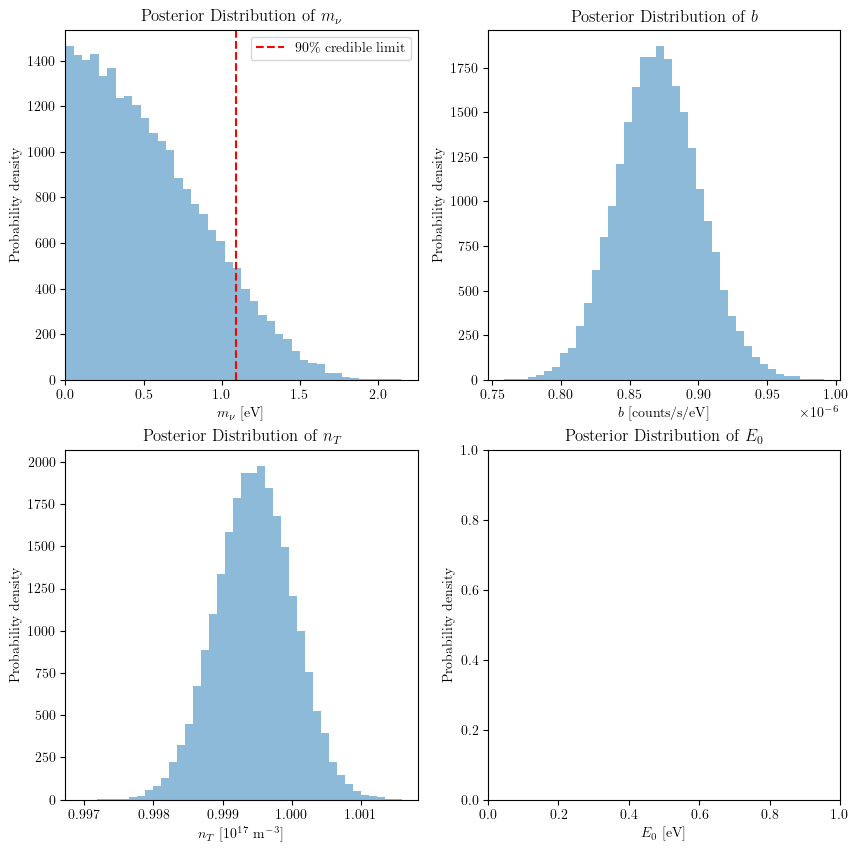

In [22]:
# Plot a histogram of the posterior samples for m_nu and show the 1 and two sigma intervals
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Get the one-sided 90% credible interval for m_nu
m_nu_samples = trace.posterior['m_nu'].values.flatten()
m_nu_90 = np.percentile(m_nu_samples, 90)
print(f"One-sided 90% credible interval for m_nu: {m_nu_90} eV")

ax[0,0].hist(np.array(trace.posterior['m_nu']).flatten(), bins=40, alpha=0.5)
ax[0,0].set_xlabel(r'$m_\nu$ [eV]')
ax[0,0].set_ylabel('Probability density')
ax[0,0].set_title(r'Posterior Distribution of $m_\nu$')
ax[0,0].set_xlim(0, None)
ax[0,0].axvline(m_nu_90, color='red', linestyle='--', label=r'$90\%$ credible limit')
ax[0,0].legend()

ax[0,1].hist(np.array(trace.posterior['bkgRate']).flatten(), bins=40, alpha=0.5)
ax[0,1].set_xlabel(r'$b$ [counts/s/eV]')
ax[0,1].set_ylabel('Probability density')
ax[0,1].set_title(r'Posterior Distribution of $b$')

ax[1,0].hist(np.array(trace.posterior['nT']).flatten(), bins=40, alpha=0.5)
ax[1,0].set_xlabel(r'$n_T$ [$10^{17}$ m$^{-3}$]')
ax[1,0].set_ylabel('Probability density')
ax[1,0].set_title(r'Posterior Distribution of $n_T$')

# ax[1,1].hist(np.array(trace.posterior['E0']).flatten(), bins=40, alpha=0.5)
ax[1,1].set_xlabel(r'$E_0$ [eV]')
ax[1,1].set_ylabel('Probability density')
ax[1,1].set_title(r'Posterior Distribution of $E_0$')

plt.show()

In [25]:
def CreateAndAnalyseData(numDens: float, tLive: float, volume: float, mNu: float, 
                         E0: float, deltaE: float, b: float,
                         energyWindow: tuple[float, float] = (18.5e3, 18.7e3)):
    """
    Create a simulated neutrino mass dataset and then perform a Bayesian 
    analysis to get limits on the parameters

    Parameters
    ----------
    
    numDens : float
        Number density of tritium atoms in m^-3
    tLive : float
        Live time of the detector in seconds
    volume : float
        Effective volume of the detector in m^3
    mNu : float
        Neutrino mass in eV
    E0 : float
        Endpoint energy in eV 
    deltaE : float
        Energy bin width in eV
    b : float
        Background event rate in eV^-1 s^-1
    energyWindow : tuple of float, optional
        Energy window for the events in eV (default is (17.7, 18.7))

    Returns
    -------
    """
    events = np.concatenate((GenerateSignalEvents(numDens, tLive, volume, mNu, E0, energyWindow), 
                             GenerateBkgEvents(b, tLive, energyWindow)))
    bins = np.arange(ENERGY_WINDOW[0], ENERGY_WINDOW[1] + deltaE, deltaE)
    eventHist, eventHistEdges = np.histogram(events, bins=bins)
    eventHistCentres = (eventHistEdges[:-1] + eventHistEdges[1:]) / 2

    with pm.Model() as model:
        # Define priors
        m_nu = pm.Uniform('m_nu', lower=0.0, upper=3.0)  # Neutrino mass in eV
        nT_DIV17 = pm.Normal('nT', mu=numDens / 1e17, sigma=2e16 / 1e17)
        bkgRate = pm.HalfNormal('bkgRate', sigma=b * 4)  # Background rate in counts per second per eV
        E_0 = pm.Normal('E_0', mu=E0, sigma=1.0)  # Endpoint energy in eV
        
        bkgMu = bkgRate * T_LIVE * dE
        sigMu = CalcMuSignal_pytensor(m_nu, E_0, eventHistEdges, T_LIVE, nT_DIV17 * 1e17,
                                      T_VOLUME, subdivisionStep=STEP_SIZE)
        muTot = sigMu + bkgMu

        Y_obs = pm.Poisson('Y_obs', mu=muTot + 1e-40, observed=eventHist)

    with signalPlusBkg:
        trace = pm.sample_prior_predictive(samples=1000)
        trace.extend(pm.sample(4000, tune=2000, return_inferencedata=True, target_accept=0.99))

    return trace

In [26]:
trace1eV = CreateAndAnalyseData(NUM_DENS, T_LIVE, T_VOLUME, 0.0, ENDPOINT_ENERGY_EV, 100e-3, myB, ENERGY_WINDOW)

Sampling: [Y_obs, bkgRate, m_nu, nT]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [m_nu, nT, bkgRate]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 140 seconds.


In [ ]:
# Plot a histogram of the posterior samples for m_nu and show the 1 and two sigma intervals
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].hist(np.array(trace1eV.posterior['m_nu']).flatten(), bins=40, density=True, alpha=0.5)
ax[0,0].set_xlabel(r'$m_\nu$ [eV]')
ax[0,0].set_ylabel('Probability density')
ax[0,0].set_title(r'Posterior Distribution of $m_\nu$')

ax[0,1].hist(np.array(trace1eV.posterior['bkgRate']).flatten(), bins=40, density=True, alpha=0.5)
ax[0,1].set_xlabel(r'$b$ [counts/s/eV]')
ax[0,1].set_ylabel('Probability density')
ax[0,1].set_title(r'Posterior Distribution of $b$')

ax[1,0].hist(np.array(trace1eV.posterior['nT']).flatten(), bins=40, density=True, alpha=0.5)
ax[1,0].set_xlabel(r'$n_T$ [$10^{17}$ m$^{-3}$]')
ax[1,0].set_ylabel('Probability density')
ax[1,0].set_title(r'Posterior Distribution of $n_T$')

ax[1,1].hist(np.array(trace1eV.posterior['E0']).flatten(), bins=40, density=True, alpha=0.5)
ax[1,1].set_xlabel(r'$E_0$ [eV]')
ax[1,1].set_ylabel('Probability density')
ax[1,1].set_title(r'Posterior Distribution of $E_0$')

## Using unbinned model data

In [ ]:
from scipy.integrate import quad

def CreateAndAnalyseUnbinnedData(numDens: float, tLive: float, volume: float, 
                                 mNu: float, E0: float,  b: float,
                                 energyWindow: tuple[float, float] = (18.5e3, 18.7e3)):
    """
    Create a simulated neutrino mass dataset and then perform a Bayesian 
    analysis to get limits on the parameters

    Parameters
    ----------
    
    numDens : float
        Number density of tritium atoms in m^-3
    tLive : float
        Live time of the detector in seconds
    volume : float
        Effective volume of the detector in m^3
    mNu : float
        Neutrino mass in eV
    E0 : float
        Endpoint energy in eV 
    b : float
        Background event rate in eV^-1 s^-1
    energyWindow : tuple of float, optional
        Energy window for the events in eV (default is (17.7, 18.7))

    Returns
    -------
    """
    events = GenerateSignalEvents(numDens, tLive, volume, mNu, E0, energyWindow)

    with pm.Model() as model:
        # Define priors
        m_nu = pm.Uniform('m_nu', lower=0.0, upper=10.0)  # Neutrino mass in eV
        E_0 = pm.Normal('E_0', mu=E0, sigma=1.0)  # Endpoint energy in eV

        # Compute a normalised spectrum to facilitate calculating the LL
        energyGrid = np.arange(energyWindow[0], energyWindow[1], 5e-3)  # in eV
        def normalisedSpectrum(nuMass, endpointE):
            unnorm = SpectrumModel(energyGrid, nuMass, endpointE)
            norm = pt.sum(unnorm * (energyGrid[1] - energyGrid[0]))
            return unnorm / norm  

        def ComputeLL(EVals, m_nu, E_0):
            pdfVals = normalisedSpectrum(m_nu, E_0)
            # Interpolate between the pre-calculated points to get the PDF at
            # the observed events
            interpVals = pt.interp(EVals, energyGrid, pdfVals)
            return pt.sum(pm.math.log(interpVals + 1e-40))

        logp = ComputeLL(events, m_nu, E_0)
        pm.Potential("unbinned", logp)

        #trace = pm.sample_prior_predictive(samples=1000)
        trace.extend(pm.sample(4000, tune=2000, return_inferencedata=True, step=pm.Metropolis()))

    return trace

In [ ]:
traceUnbinned = CreateAndAnalyseUnbinnedData(NUM_DENS, T_LIVE, T_VOLUME, 0.0, 
                                             ENDPOINT_ENERGY_EV, myB, (18.55e3, 18.6e3))

In [ ]:
# Plot a histogram of the posterior samples for m_nu and show the 1 and two sigma intervals
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].hist(np.array(traceUnbinned.posterior['m_nu']).flatten(), bins=40, density=True, alpha=0.5)
ax[0,0].set_xlabel(r'$m_\nu$ [eV]')
ax[0,0].set_ylabel('Probability density')
ax[0,0].set_title(r'Posterior Distribution of $m_\nu$')

ax[0,1].hist(np.array(traceUnbinned.posterior['bkgRate']).flatten(), bins=40, density=True, alpha=0.5)
ax[0,1].set_xlabel(r'$b$ [counts/s/eV]')
ax[0,1].set_ylabel('Probability density')
ax[0,1].set_title(r'Posterior Distribution of $b$')

ax[1,0].hist(np.array(traceUnbinned.posterior['nT']).flatten(), bins=40, density=True, alpha=0.5)
ax[1,0].set_xlabel(r'$n_T$ [$10^{17}$ m$^{-3}$]')
ax[1,0].set_ylabel('Probability density')
ax[1,0].set_title(r'Posterior Distribution of $n_T$')

ax[1,1].hist(np.array(traceUnbinned.posterior['E0']).flatten(), bins=40, density=True, alpha=0.5)
ax[1,1].set_xlabel(r'$E_0$ [eV]')
ax[1,1].set_ylabel('Probability density')
ax[1,1].set_title(r'Posterior Distribution of $E_0$')